# Group Geoffroy Dufay, Louis Lapassat : diabete aaa

In [2]:
#########################
### loading libraries ###
#########################

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

##############################
### fixing some parameters ###
##############################

sns.set(style="darkgrid", palette="muted", font_scale=1.5)
random_seed = 141421

# Loading the dataset

In [4]:
diabete = datasets.load_diabetes()
df = pd.DataFrame(data=diabete.data, columns=diabete.feature_names)
df['target'] = diabete.target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline. 

**Note**: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1). For instance if `f` is a feature we have:

$$ \frac{f - mean(f)}{std(f)} \times n\_samples$$ 

# Tune_Plot function that will test all our models

It uses a conbination of grid search CV to optimize on a set of parameters. The function works as follow:

 * Data normalization (feature, target) 
 * Iteration with GridSearchCV (just do GridSearchCV but n-time to improve stability of "best set of parameters")
 * Creat a new model with the "best set of parameters"
 * One test with train/test split dataset 
 * Multiple tests with different train/test dataset (average result)
 * Error distribution

To ensure that we can compare different models we set a random seed for every function call. Type `help(tune_plot)` for more information.

In [5]:
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

def tune_plot(model, param, X, y, normalize=1, iter_gridsearch=1, nb_cv=5, test_size=0.3, seed=141421):
    
    """
    Tune a given model with GridSearchCV and give for accuracy results with a confusion matrix.
    
    First you need to make sure that you imported the library for your model!
    
    model = classificator
    param = parameters of your classificator that you want to tune 
    X = data for prediction (DataFrame pref)
    y = target to predict (DataFrame pref)
    normalize = True/False (normalize both X and y with StandardScaler and LabelEncoder)
    iter_gridsearch = number of iteration for GridSearchCV (can be usefull if your model involve randomness)
    nb_cv = number of cross validation
    test_size = test size in percent (splitting train and test set)
    seed = seed for random state
    """
    
    print(" ************************* ", str(model), " ************************* ")
    
    ######################
    ### Normalize data ###
    ######################
    
    if normalize:
        yy = (y - np.mean(y)) / np.std(y)

        scaler = StandardScaler()
        scaler.fit(X)
        XX = scaler.transform(X)
    else:
        yy = y
        XX = X
    
    ####################
    ### GridSearchCV ###
    ####################
    
    if iter_gridsearch > 1:
        keys = param.keys()
        dic_result = {key: [] for key in keys}
        for i in tqdm(range(iter_gridsearch)):
            clf = model()
            result_grid_search = GridSearchCV(estimator=clf, param_grid=param, cv=nb_cv, return_train_score=False)
            result_grid_search.fit(XX, yy)
            for key in keys:
                dic_result[key].append(result_grid_search.best_params_[key])
        best_param = {}
        for key in keys:
            track = {}
            for item in dic_result[key]: 
                if item not in track:
                    track[item] = 0
                else:
                    track[item] += 1
            best_param[key] = max(track, key=track.get)
    else:
        clf = model()
        result_grid_search = GridSearchCV(estimator=clf, param_grid=param, cv=nb_cv)
        result_grid_search.fit(XX, yy)
        best_param = result_grid_search.best_params_
    
    print('best parameters: ', best_param)
    
    ####################
    ### update model ###
    ####################
    
    clf = model(**best_param)
    
    ########################
    ### train / test set ###
    ########################
    
    x_train, x_test, y_train, y_test = train_test_split(XX, yy, test_size=test_size, random_state=seed)
    
    #################
    ### fit model ###
    #################    
    
    clf.fit(x_train, y_train)
    
    #############
    ### Score ###
    #############
    print('\n')
    
    print("Mean squared error (on test set): %.2f" % mean_squared_error(y_test, clf.predict(x_test)))
    print('Variance score (max_value=1 for perfect prediction): %.2f' % r2_score(y_test, clf.predict(x_test)))
    
    #####################
    ### Average score ###
    #####################
    
    print('\n')
    mae = 0
    var = 0
    y_error = []
    n = 30
    for i in range(n):
        x_train, x_test, y_train, y_test = train_test_split(XX, yy, test_size=test_size, random_state=i)
        y_pred = clf.predict(x_test)
        y_error.append(list(y_test.values - y_pred))
        mae += mean_squared_error(y_test, y_pred)
        var += r2_score(y_test, y_pred)
    print("Average Mean squared error: %.2f" %(mae / n))
    print('Average Variance score (max_value=1 for perfect prediction): %.2f' %(var / n))
    
    ##########################
    ### error distribution ###
    ##########################
    
    plt.figure(figsize=(15, 6))
    plt.title('Error distribution')
    sns.distplot(y_error[0])
    
        
    return best_param

# Test of the MLPRegressor with GridSearhCV

 *************************  <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>  ************************* 



best parameters:  {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.1}


Mean squared error (on test set): 0.48
Variance score (max_value=1 for perfect prediction): 0.45


Average Mean squared error: 0.46
Average Variance score (max_value=1 for perfect prediction): 0.51


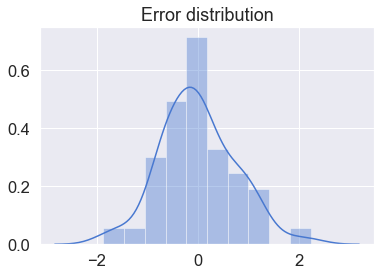

In [14]:
param = { 
    'hidden_layer_sizes' : [(50,), (75,), (100,)], # (100,) is default
    'activation' : ['relu', 'logistic', 'tanh', 'identity'], # 'relu' is default
    'solver' : ['adam', 'sgd'], # 'adam' is default
    'alpha' : [0.01, 0.1] # 0.0001 is default
    }

best_param_MLP = tune_plot(MLPRegressor, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=5, nb_cv=3, test_size=0.2, seed=141421)

# Test of the SVR with GridSearhCV

 *************************  <class 'sklearn.svm.classes.SVR'>  ************************* 



best parameters:  {'kernel': 'rbf', 'gamma': 0.01}


Mean squared error (on test set): 0.46
Variance score (max_value=1 for perfect prediction): 0.47


Average Mean squared error: 0.47
Average Variance score (max_value=1 for perfect prediction): 0.50


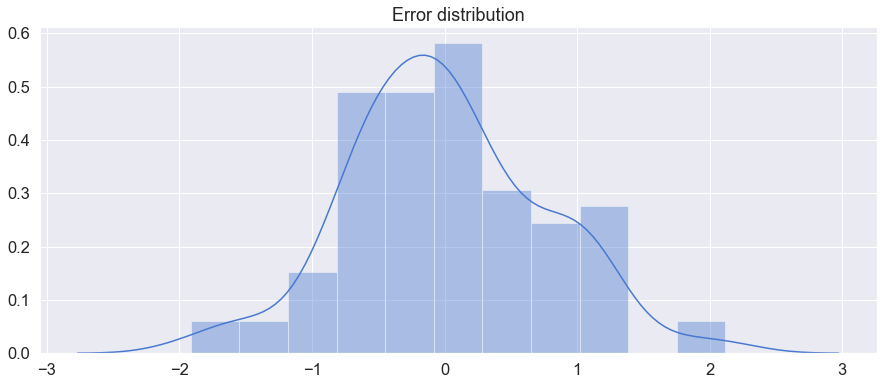

In [6]:
param = { 
    'kernel' : ['rbf', 'sigmoid'], # rbf is default
    'gamma' : [0.01, 0.1, 1] # auto is default
    }

best_param_MLP = tune_plot(SVR, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=10, nb_cv=3, test_size=0.2, seed=141421)

# Test of the Lasso with GridSearhCV

In [2]:
param = { 
    'alpha' : [0, 0.001, 5], # rbf is default
    }

best_param_MLP = tune_plot(Lasso, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=10, nb_cv=3, test_size=0.2, seed=11421)

NameError: name 'df' is not defined

# Test of the Ridge with GridSearhCV

 *************************  <class 'sklearn.linear_model.ridge.Ridge'>  ************************* 



best parameters:  {'alpha': 0}


Mean squared error (on test set): 0.48
Variance score (max_value=1 for perfect prediction): 0.45


Average Mean squared error: 0.49
Average Variance score (max_value=1 for perfect prediction): 0.48


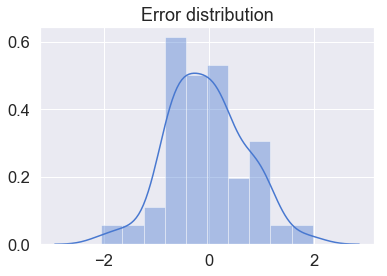

In [6]:
param = { 
    'alpha' : [0, 0.1, 0.01], # rbf is default
    }

best_param_MLP = tune_plot(Ridge, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=10, nb_cv=3, test_size=0.2, seed=141421)

# Test of the LinearRegression with GridSearhCV

 *************************  <class 'sklearn.linear_model.ridge.Ridge'>  ************************* 



best parameters:  {'fit_intercept': False}


Mean squared error (on test set): 0.47
Variance score (max_value=1 for perfect prediction): 0.46


Average Mean squared error: 0.49
Average Variance score (max_value=1 for perfect prediction): 0.48


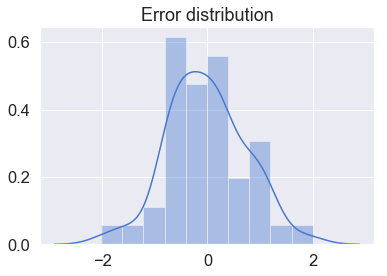

In [7]:
param = { 
    'fit_intercept' : [True, False], # rbf is default
    }

best_param_MLP = tune_plot(Ridge, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=10, nb_cv=3, test_size=0.2, seed=141421)

# Test of the GaussianProcessRegressor with GridSearhCV

 *************************  <class 'sklearn.gaussian_process.gpr.GaussianProcessRegressor'>  ************************* 



best parameters:  {'alpha': 0.1}


Mean squared error (on test set): 0.55
Variance score (max_value=1 for perfect prediction): 0.36


Average Mean squared error: 0.12
Average Variance score (max_value=1 for perfect prediction): 0.87


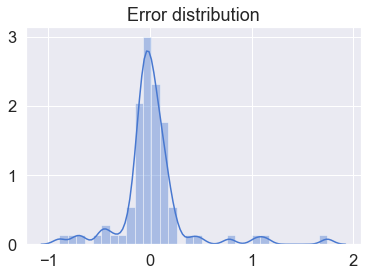

In [40]:
param = { 
    'alpha' : [1e-2, 1e-1, 1, 10] # 1e-10 is default
    }

best_param_MLP = tune_plot(GaussianProcessRegressor, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=10, nb_cv=3, test_size=0.2, seed=141421)

# Test of the GradientBoostingRegressor with GridSearhCV

 *************************  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>  ************************* 



best parameters:  {'loss': 'lad'}


Mean squared error (on test set): 0.50
Variance score (max_value=1 for perfect prediction): 0.42


Average Mean squared error: 0.34
Average Variance score (max_value=1 for perfect prediction): 0.64


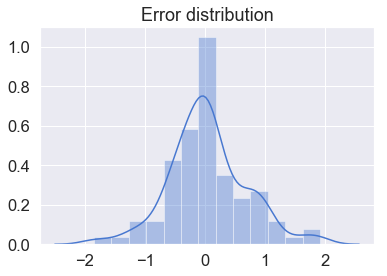

In [22]:
param = { 
    'loss' : ['ls', 'lad', 'huber', 'quantile'], # 1e-10 is default
    }

best_param_MLP = tune_plot(GradientBoostingRegressor, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=10, nb_cv=3, test_size=0.2, seed=141421)

# Test of the RandomForestRegressor with GridSearhCV

 *************************  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>  ************************* 



best parameters:  {'n_estimators': 25, 'max_depth': 3}


Mean squared error (on test set): 0.51
Variance score (max_value=1 for perfect prediction): 0.42


Average Mean squared error: 0.38
Average Variance score (max_value=1 for perfect prediction): 0.60


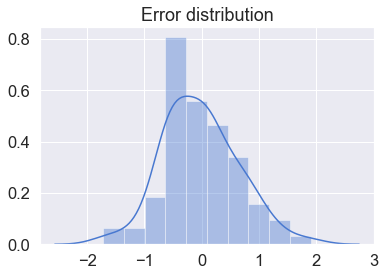

In [32]:
param = { 
    'n_estimators' : [20, 25, 30, 35], # 1e-10 is default
    'max_depth' : [3, 5, 7], # 2 is default
    }

best_param_MLP = tune_plot(GradientBoostingRegressor, param,
                          df.drop(['target'], axis=1), df['target'], normalize=True,
                          iter_gridsearch=10, nb_cv=3, test_size=0.2, seed=141421)

# Conclusion

According to our previous results we can deduce that the best model is the `GaussianProcessRegressor`.

# Test with Tensorflow (for fun)

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras import backend as K
import keras as keras

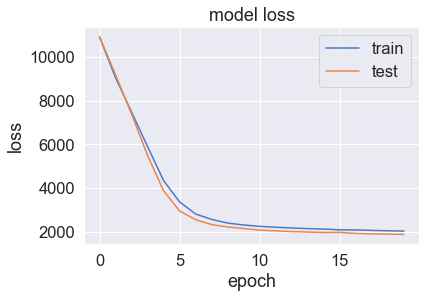

In [117]:
# create model
K.clear_session()
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, activation='sigmoid', input_dim=10, kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(50, activation='sigmoid', input_dim=10, kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(1, kernel_regularizer=keras.regularizers.l2(0.01)))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='Adadelta')
    return model

# Compile model
estimator = KerasClassifier(build_fn=baseline_model)

######################
### normalize data ###
######################

yy = (df['target'] - df['target'].mean()) / df['target'].std()

scaler = StandardScaler()
scaler.fit(df.drop(['target'], axis=1))
XX = scaler.transform(df.drop(['target'], axis=1))

#####################
### fit the model ###
#####################

history = estimator.fit(XX, yy, validation_split=0.3, epochs=20, batch_size=2, verbose=0)

#####################
### plot history ###
#####################

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()